<a href="https://colab.research.google.com/github/LaFuego20/exchange-rate-forecasting/blob/main/STGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torch-geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00


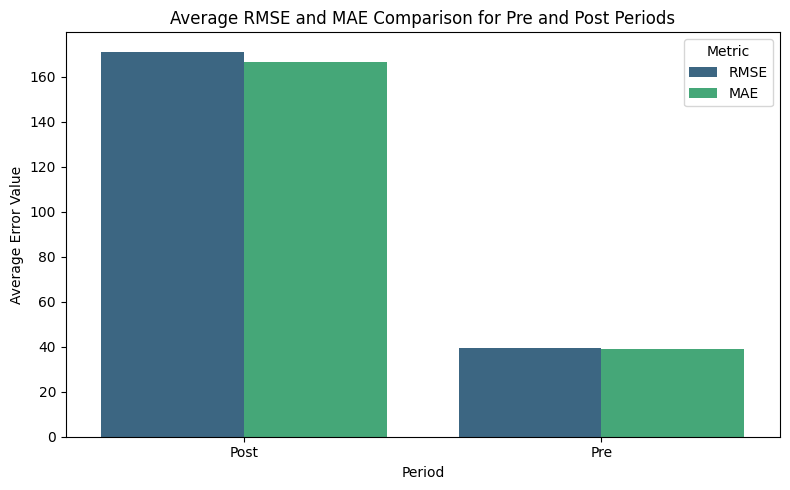

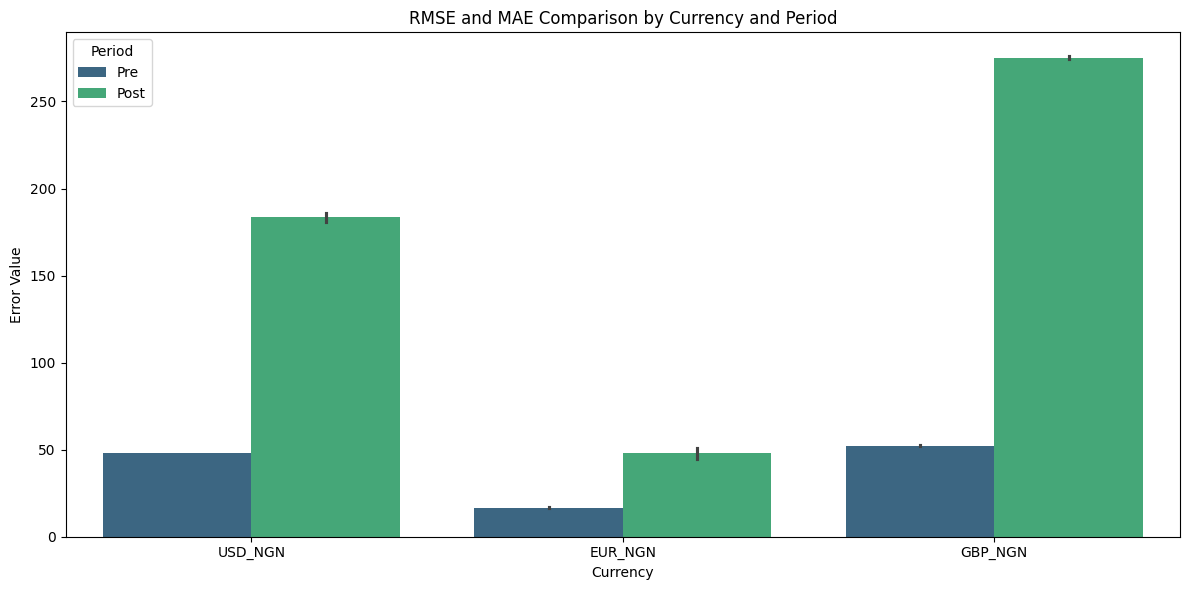

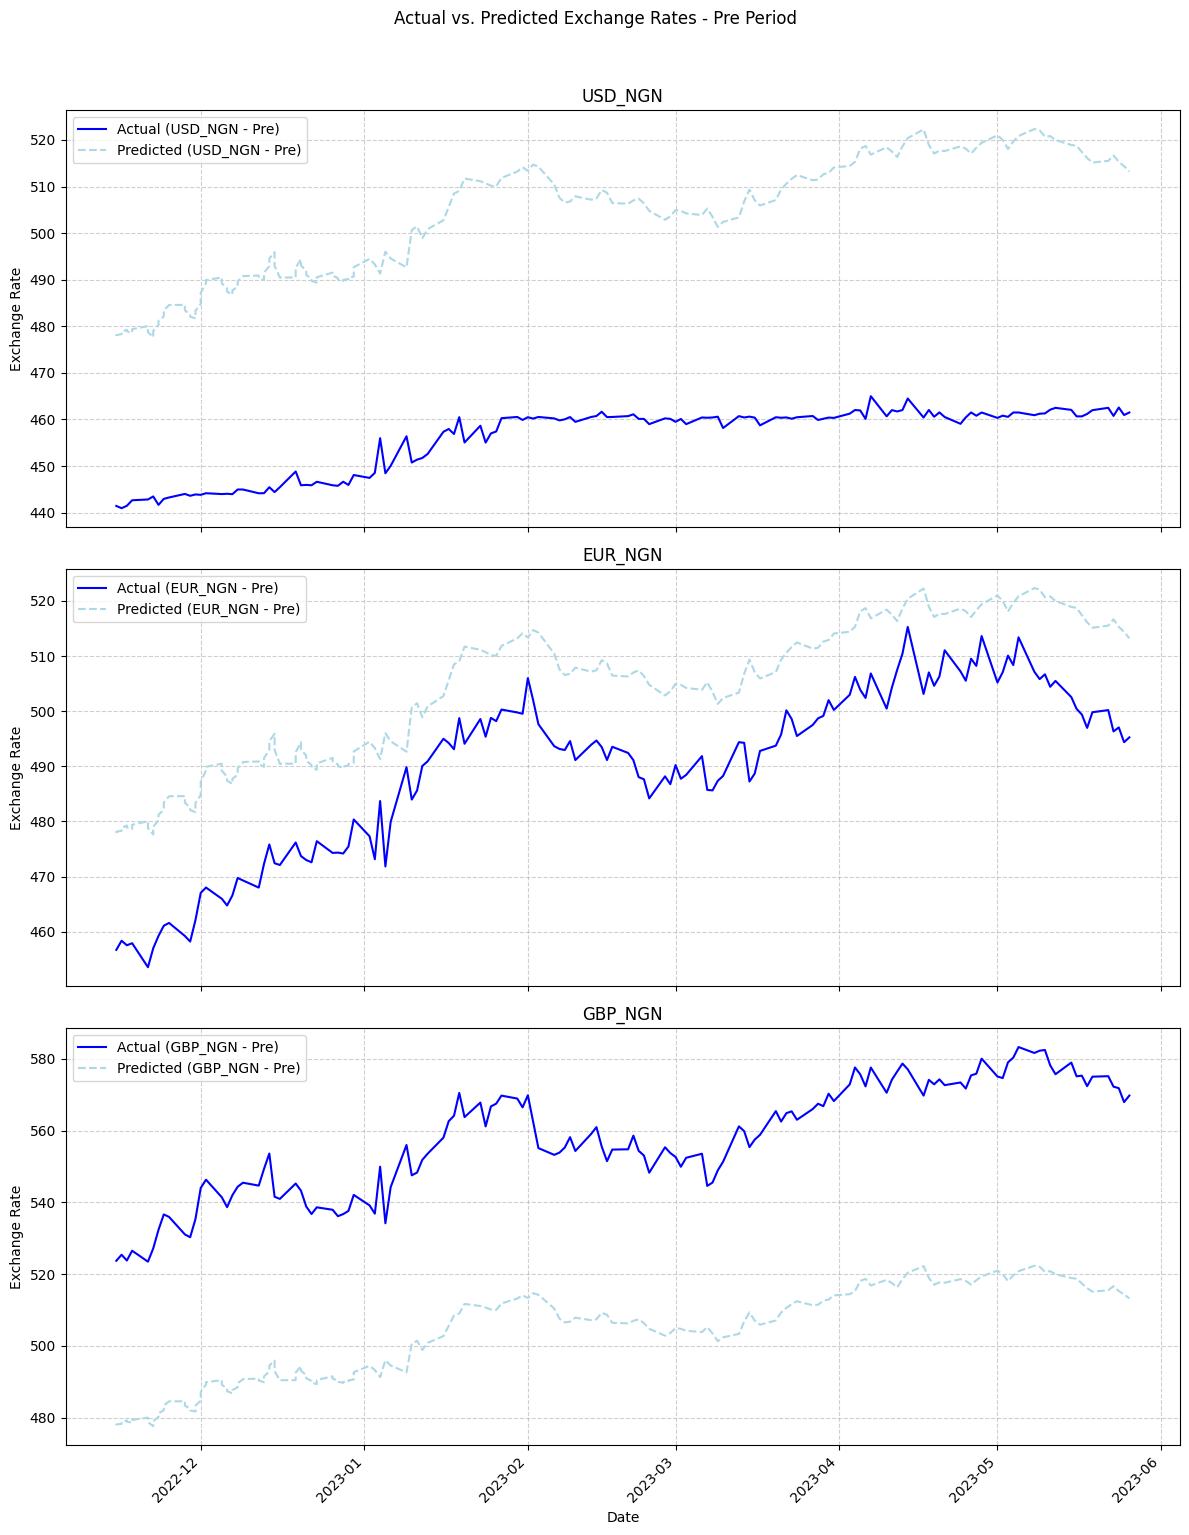

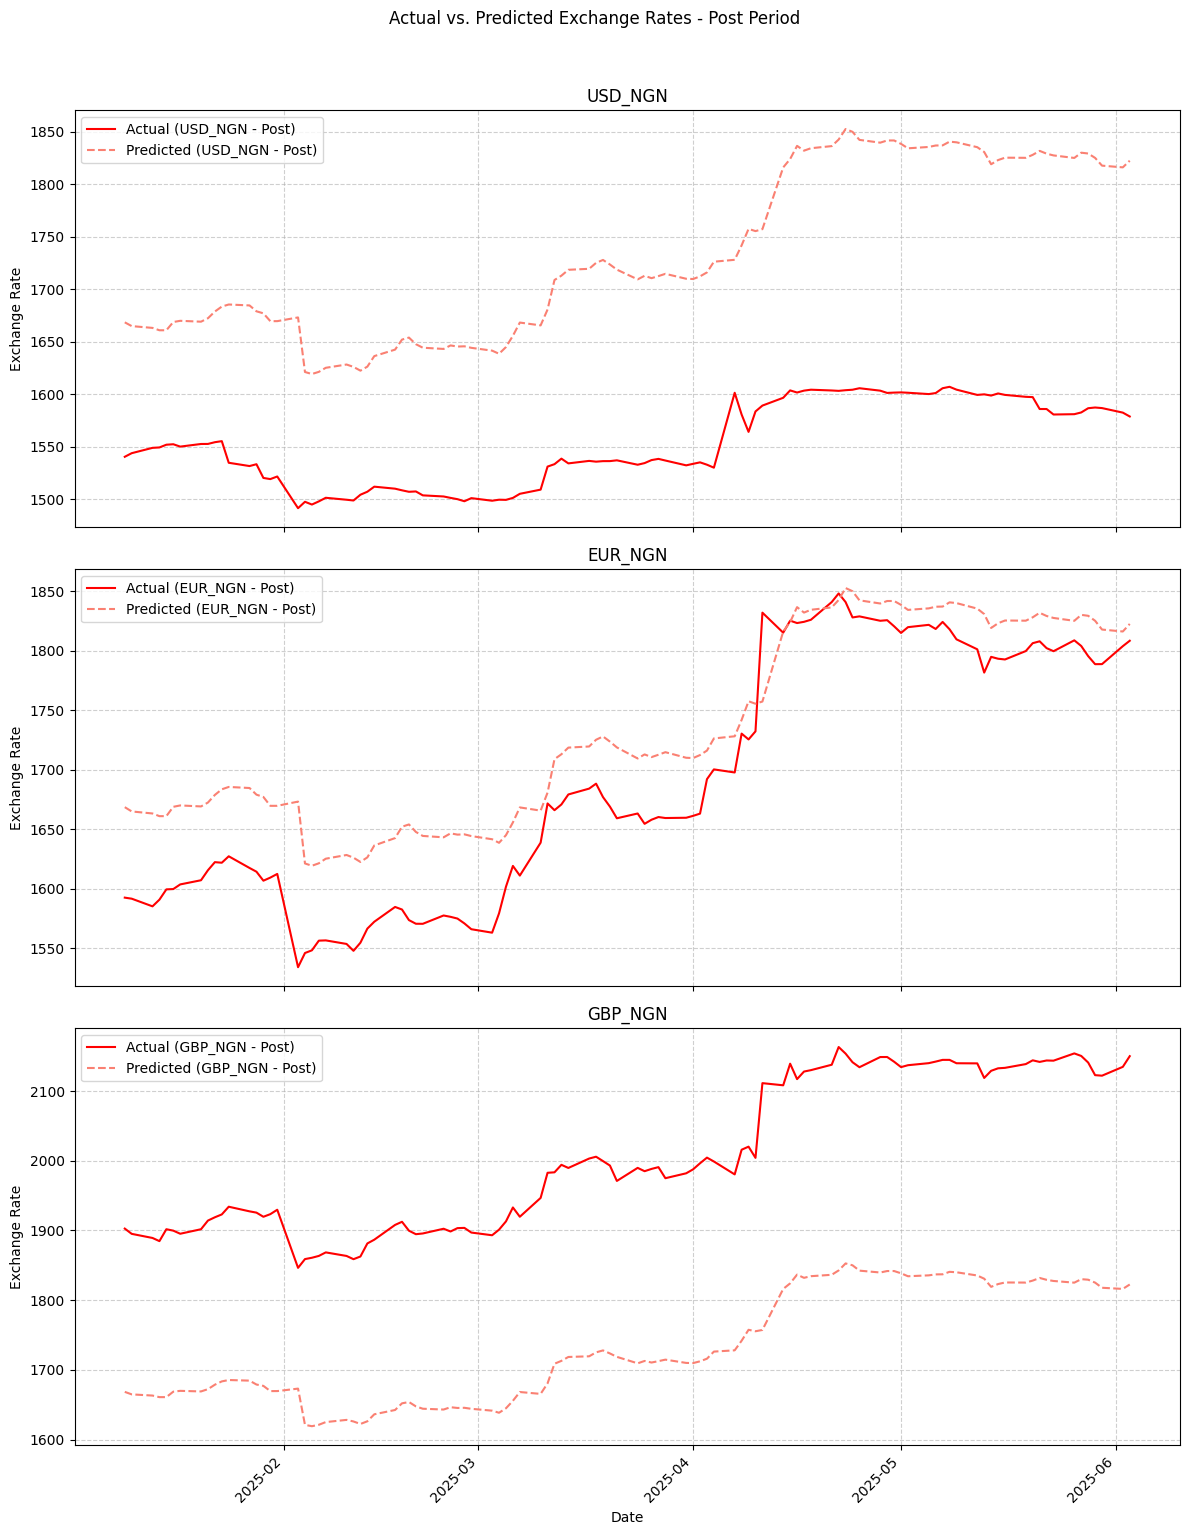

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn
import os
import random
import tensorflow as tf
import seaborn as sns

# Set random seed for reproducibility
os.environ['PYTHONHASHSEED'] = '2'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(2)
np.random.seed(2)
tf.random.set_seed(2)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and prepare data
normalized_df = pd.read_csv('/content/normalized_data.csv')
original_df = pd.read_csv('/content/merged_exchange_rates.csv')

for df in (normalized_df, original_df):
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

currency_cols = ['USD_NGN', 'EUR_NGN', 'GBP_NGN']
cutoff = pd.to_datetime('2023-05-29')
sequence_length = 10

# Function to split data into periods
def split_periods(df):
    full = df
    pre = df[df['Date'] < cutoff].reset_index(drop=True)
    post = df[df['Date'] >= cutoff].reset_index(drop=True)
    return {'Full': full, 'Pre': pre, 'Post': post}

norm_parts = split_periods(normalized_df)
raw_parts  = split_periods(original_df)

# Function to create sequence of graph data objects
def make_sequence_data_list(norm_part, raw_part):
    sequence_list = []
    edge_index = torch.tensor([[0,0,1,1,2,2],[1,2,0,2,0,1]], dtype=torch.long, device=device)

    for i in range(len(norm_part) - sequence_length):
        current_sequence_graphs = []
        for j in range(sequence_length):
            x = norm_part[currency_cols].iloc[i + j].values.reshape(-1, 1)
            x_tensor = torch.tensor(x, dtype=torch.float, device=device)
            current_sequence_graphs.append(Data(x=x_tensor, edge_index=edge_index))

        if i + sequence_length < len(raw_part):
            y = raw_part[currency_cols].iloc[i + sequence_length].values.reshape(-1, 1)
            y_tensor = torch.tensor(y, dtype=torch.float, device=device)
            sequence_list.append((current_sequence_graphs, y_tensor, i + sequence_length))
        else:
            continue

    return sequence_list

# Define the Spatio-Temporal Graph Neural Network (STGNN) model
class STGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, sequence_length=10):
        super().__init__()
        self.temporal_conv = nn.Conv1d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.gcn = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.sequence_length = sequence_length

    def forward(self, data_list):
        if not data_list:
            return torch.empty(0, self.lin.out_features, device=self.lin.weight.device)

        num_nodes = data_list[0].x.size(0)
        edge_index = data_list[0].edge_index.to(data_list[0].x.device)

        x_temporal = torch.stack([data.x.to(device) for data in data_list], dim=0)
        x_temporal = x_temporal.permute(1, 2, 0)

        x_temporal_out = self.temporal_conv(x_temporal)

        x_spatial_in = x_temporal_out[:, :, -1]

        x_spatial_out = F.relu(self.gcn(x_spatial_in, edge_index))

        out = self.lin(x_spatial_out)

        return out

# Training and evaluation function for sequences
def train_eval_sequence(part_name, norm_df_part, raw_df_part):
    sequence_data_list = make_sequence_data_list(norm_df_part, raw_df_part)

    if not sequence_data_list:
        dummy_results = []
        for cur in currency_cols:
             dummy_results.append({'Period': part_name, 'Currency':cur, 'RMSE':0.0,'MAE':0.0,'MAPE':0.0,'MSE':0.0})
        return dummy_results, {}, {}, {}

    N = len(sequence_data_list)
    split = int(0.8*N)
    train_sequence_list = sequence_data_list[:split]
    test_sequence_list  = sequence_data_list[split:]

    test_indices = [item[2] for item in test_sequence_list]
    test_dates = raw_df_part['Date'].iloc[test_indices].reset_index(drop=True)

    model = STGNN(in_channels=1, hidden_channels=32, out_channels=1, sequence_length=sequence_length).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    model.train()
    for epoch in range(101):
        total_loss = 0
        for seq_graphs, target, _ in train_sequence_list:
            optimizer.zero_grad()
            pred = model(seq_graphs)
            loss = F.mse_loss(pred, target.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


    model.eval()
    y_true_list = []
    y_pred_list = []
    with torch.no_grad():
        for seq_graphs, target, _ in test_sequence_list:
            pred = model(seq_graphs).cpu().numpy()
            y_true = target.cpu().numpy()
            y_pred_list.append(pred.flatten())
            y_true_list.append(y_true.flatten())

    if not y_true_list:
         dummy_results = []
         for cur in currency_cols:
              dummy_results.append({'Period': part_name, 'Currency':cur, 'RMSE':0.0,'MAE':0.0,'MAPE':0.0,'MSE':0.0})
         return dummy_results, {}, {}, {}

    y_true_all = np.array(y_true_list)
    y_pred_all = np.array(y_pred_list)

    plot_data = {
        'dates': test_dates,
        'y_true': y_true_all,
        'y_pred': y_pred_all
    }

    results = []
    plots_dir = "stgnn_plots"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    for idx, cur in enumerate(currency_cols):
        mse = mean_squared_error(y_true_all[:,idx], y_pred_all[:,idx])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true_all[:,idx], y_pred_all[:,idx])

        valid_indices = y_true_all[:,idx] != 0
        if np.sum(valid_indices) > 0:
            mape = np.mean(np.abs((y_true_all[valid_indices,idx] - y_pred_all[valid_indices,idx]) / y_true_all[valid_indices,idx])) * 100
        else:
            mape = np.nan

        results.append({'Period': part_name, 'Currency':cur, 'RMSE':round(rmse, 4),'MAE':round(mae, 4),'MAPE':round(mape, 4) if not np.isnan(mape) else np.nan,'MSE':round(mse, 4)})

    return results, plot_data, y_true_all, y_pred_all

# Main execution block
all_res = []
plot_data_all = {}
y_true_all_periods = {}
y_pred_all_periods = {}

if 'norm_parts' in locals() and 'raw_parts' in locals():
    for name, norm_part in norm_parts.items():
        raw_part = raw_parts[name]
        res, plot_data_period, y_true_period, y_pred_period = train_eval_sequence(name, norm_part, raw_part)
        all_res.extend(res)
        plot_data_all[name] = plot_data_period
        y_true_all_periods[name] = y_true_period
        y_pred_all_periods[name] = y_pred_period

    df_results = pd.DataFrame(all_res)
    df_results.to_csv('stgnn_results.csv', index=False)

    # Prepare data for average metrics plot
    df_results_filtered = df_results.drop(columns=['MSE', 'MAPE'])
    average_metrics = df_results_filtered.groupby('Period')[['RMSE', 'MAE']].mean().reset_index()
    average_metrics_filtered = average_metrics[average_metrics['Period'].isin(['Pre', 'Post'])]

    # Plot average metrics
    df_melted_avg = average_metrics_filtered.melt(id_vars=['Period'],
                                                  value_vars=['RMSE', 'MAE'],
                                                  var_name='Metric',
                                                  value_name='Value')

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Period', y='Value', hue='Metric', data=df_melted_avg, palette='viridis')
    plt.title('Average RMSE and MAE Comparison for Pre and Post Periods')
    plt.xlabel('Period')
    plt.ylabel('Average Error Value')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.savefig('average_metrics_comparison.png') # Save the plot as PNG
    plt.show()

    # Prepare data for individual currency metrics plot
    df_results_filtered_periods = df_results[df_results['Period'].isin(['Pre', 'Post'])].drop(columns=['MSE', 'MAPE'])

    # Plot individual currency metrics
    df_melted_currency = df_results_filtered_periods.melt(id_vars=['Period', 'Currency'],
                                              value_vars=['RMSE', 'MAE'],
                                              var_name='Metric',
                                              value_name='Value')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Currency', y='Value', hue='Period', data=df_melted_currency, palette='viridis')
    plt.title('RMSE and MAE Comparison by Currency and Period')
    plt.xlabel('Currency')
    plt.ylabel('Error Value')
    plt.legend(title='Period')
    plt.tight_layout()
    plt.savefig('currency_metrics_comparison.png') # Save the plot as PNG
    plt.show()

    # Plot actual vs. predicted values for each currency pair - Pre Period
    currencies = currency_cols
    fig_pre, axes_pre = plt.subplots(nrows=len(currencies), ncols=1, figsize=(12, 5 * len(currencies)), sharex=True)
    fig_pre.suptitle('Actual vs. Predicted Exchange Rates - Pre Period', y=1.02)

    for i, currency in enumerate(currencies):
        y_true_pre = y_true_all_periods['Pre'][:, currency_cols.index(currency)]
        y_pred_pre = y_pred_all_periods['Pre'][:, currency_cols.index(currency)]
        test_dates_pre = plot_data_all['Pre']['dates']

        ax = axes_pre[i] if len(currencies) > 1 else axes_pre

        ax.plot(test_dates_pre, y_true_pre, label=f'Actual ({currency} - Pre)', color='blue')
        ax.plot(test_dates_pre, y_pred_pre, label=f'Predicted ({currency} - Pre)', linestyle='--', color='lightblue')

        ax.set_title(f'{currency}')
        ax.set_ylabel("Exchange Rate")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    if len(currencies) > 1:
        axes_pre[-1].set_xlabel("Date")
    else:
        axes_pre.set_xlabel("Date")

    plt.tight_layout()
    plt.savefig('pre_period_predictions.png') # Save the plot as PNG
    plt.show()

    # Plot actual vs. predicted values for each currency pair - Post Period
    fig_post, axes_post = plt.subplots(nrows=len(currencies), ncols=1, figsize=(12, 5 * len(currencies)), sharex=True)
    fig_post.suptitle('Actual vs. Predicted Exchange Rates - Post Period', y=1.02)

    for i, currency in enumerate(currencies):
        y_true_post = y_true_all_periods['Post'][:, currency_cols.index(currency)]
        y_pred_post = y_pred_all_periods['Post'][:, currency_cols.index(currency)]
        test_dates_post = plot_data_all['Post']['dates']

        ax = axes_post[i] if len(currencies) > 1 else axes_post

        ax.plot(test_dates_post, y_true_post, label=f'Actual ({currency} - Post)', color='red')
        ax.plot(test_dates_post, y_pred_post, label=f'Predicted ({currency} - Post)', linestyle='--', color='salmon')

        ax.set_title(f'{currency}')
        ax.set_ylabel("Exchange Rate")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    if len(currencies) > 1:
        axes_post[-1].set_xlabel("Date")
    else:
        axes_post.set_xlabel("Date")


    plt.tight_layout()
    plt.savefig('post_period_predictions.png') # Save the plot as PNG
    plt.show()
else:
    print("Error: Data splits (norm_parts, raw_parts) are not available. Please ensure data loading steps are included.")

In [ ]:
display(df_results.drop(columns=['MSE']))

In [ ]:
# Prepare combined plot data
currencies = currency_cols
fig_combined, axes_combined = plt.subplots(nrows=len(currencies), ncols=1, figsize=(12, 5 * len(currencies)), sharex=True)
fig_combined.suptitle('Actual vs. Predicted Exchange Rates - Combined Pre and Post Periods', y=1.02)

for i, currency in enumerate(currencies):
    # Combine Pre and Post data for plotting
    y_true_combined = np.concatenate((y_true_all_periods['Pre'][:, currency_cols.index(currency)],
                                       y_true_all_periods['Post'][:, currency_cols.index(currency)]))
    y_pred_combined = np.concatenate((y_pred_all_periods['Pre'][:, currency_cols.index(currency)],
                                       y_pred_all_periods['Post'][:, currency_cols.index(currency)]))
    test_dates_combined = pd.concat([plot_data_all['Pre']['dates'], plot_data_all['Post']['dates']]).reset_index(drop=True)


    ax = axes_combined[i] if len(currencies) > 1 else axes_combined

    # Plot combined data
    ax.plot(test_dates_combined, y_true_combined, label=f'Actual ({currency})', color='blue')
    ax.plot(test_dates_combined, y_pred_combined, label=f'Predicted ({currency})', linestyle='--', color='red')


    ax.set_title(f'{currency}')
    ax.set_ylabel("Exchange Rate")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

if len(currencies) > 1:
    axes_combined[-1].set_xlabel("Date")
else:
    axes_combined.set_xlabel("Date")


plt.tight_layout()
plt.savefig('combined_period_predictions.eps') # Save the plot as EPS
plt.show()